In [ ]:
import cv2
import numpy as np
import os
from natsort import natsorted
import matplotlib.pyplot as plt

In [ ]:
video_path = 'download.mp4'
cap = cv2.VideoCapture(video_path)

In [ ]:
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

In [4]:
frame_output_dir = "output_frames"
segment_output_dir = "output_segments"
os.makedirs(frame_output_dir, exist_ok=True)
os.makedirs(segment_output_dir, exist_ok=True)

In [ ]:
output_dir = "temporal_segments"
os.makedirs(output_dir, exist_ok=True)

In [6]:
scene_threshold = 30.0 
segmentation_threshold = 128

In [7]:
def save_frames(video_cap, output_dir):
    frame_id = 0
    while video_cap.isOpened():
        ret, frame = video_cap.read()
        if not ret:
            break
        frame_file = f"{output_dir}/frame_{frame_id:04d}.png"
        cv2.imwrite(frame_file, frame)
        frame_id += 1
    print(f"Frames saved to '{output_dir}'")
    return frame_id

In [8]:
frame_count = save_frames(cap, frame_output_dir)
cap.release()

Frames saved to 'output_frames'


In [9]:
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Could not reopen video.")
    exit()

In [10]:
scene_changes = []
frame_id = 0
prev_frame = None
frame_results = []

In [ ]:
scene_threshold = 30.0  
canny_threshold1 = 100  
canny_threshold2 = 200  

In [ ]:
def segment_frame(frame):
    edges_red = cv2.Canny(frame[:, :, 2], canny_threshold1, canny_threshold2)
    edges_green = cv2.Canny(frame[:, :, 1], canny_threshold1, canny_threshold2)
    edges_blue = cv2.Canny(frame[:, :, 0], canny_threshold1, canny_threshold2)
    segmented = cv2.bitwise_or(edges_red, edges_green)
    segmented = cv2.bitwise_or(segmented, edges_blue)
    
    return segmented



In [13]:
def detect_scene_cut(prev_frame, current_frame):
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    current_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
    diff = cv2.absdiff(prev_gray, current_gray)
    mean_diff = np.mean(diff)
    return mean_diff

In [14]:
cap = cv2.VideoCapture(video_path)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    segmented_frame = segment_frame(frame)
    segment_file = f"{segment_output_dir}/segmented_{frame_id:04d}.png"
    cv2.imwrite(segment_file, segmented_frame)

    if prev_frame is not None:
        frame_diff = detect_scene_cut(prev_frame, frame)
        if frame_diff > scene_threshold:
            scene_changes.append((frame_id, frame_diff))
            frame_results.append((frame_id, frame, segmented_frame))

    prev_frame = frame.copy()
    frame_id += 1

cap.release()

In [ ]:
back_sub = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50, detectShadows=True)
frame_id = 0

In [16]:
cap = cv2.VideoCapture(video_path)
frame_id=0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    fg_mask = back_sub.apply(frame)

    _, fg_thresh = cv2.threshold(fg_mask, 200, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(fg_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    frame_with_contours = frame.copy()
    cv2.drawContours(frame_with_contours, contours, -1, (0, 255, 0), 2)
    segment_file = f"{output_dir}/segmented_frame_{frame_id:04d}.png"
    cv2.imwrite(segment_file, frame_with_contours)
    frame_id += 1

cap.release()
print(f"Segmentation complete in {output_dir}")


Segmentation complete in temporal_segments


In [17]:
output_video_path = 'temporal_output_video.mp4'
fps = 30
frame_files = [f for f in os.listdir(output_dir) if f.endswith('.png')]
frame_files = natsorted(frame_files)


In [ ]:

first_frame = cv2.imread('temporal_segments\segmented_frame_0000.png')
height, width, layers = first_frame.shape

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

for frame_file in frame_files:
    frame_path = os.path.join(output_dir, frame_file)
    frame = cv2.imread(frame_path)
    if frame is None:
        print(f"Error: Could not load frame '{frame_path}'")
        continue
    out.write(frame)

out.release()
print(f"Video saved as '{output_video_path}'")


Video saved as 'temporal_output_video.mp4'


In [19]:
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

In [ ]:
def detect_scene_cut(prev_frame, current_frame):
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    current_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
    diff = cv2.absdiff(prev_gray, current_gray)
    mean_diff = np.mean(diff)
    return mean_diff

In [21]:
hard_cut_threshold = 30.0 
soft_cut_threshold = 10.0 
segmentation_threshold = 128 

hard_cuts = []
soft_cuts_by_group = {}
frame_id = 0
prev_frame = None
current_group = -1

In [ ]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_file = f"output_frames/frame_{frame_id:04d}.png"
    segment_file = f"output_segments/segmented_{frame_id:04d}.png"

    if prev_frame is not None:
        frame_diff = detect_scene_cut(prev_frame, frame)

        if frame_diff > hard_cut_threshold:
            current_group += 1
            hard_cuts.append((frame_id, frame_diff))
            soft_cuts_by_group[current_group] = []

        elif frame_diff > soft_cut_threshold:
            if current_group >= 0:
                soft_cuts_by_group[current_group].append(frame_id)

    prev_frame = frame.copy()
    frame_id += 1

cap.release()
print("Detected Hard Cuts:", hard_cuts)
print("Detected Soft Cuts grouped by Hard Cuts:", soft_cuts_by_group)


Detected Hard Cuts: [(15, 51.78541422716628), (31, 40.48255269320843), (124, 37.72407542935207), (202, 50.49678229898517)]
Detected Soft Cuts grouped by Hard Cuts: {0: [], 1: [101], 2: [160, 161, 162, 172, 173, 174, 175], 3: [203, 204]}


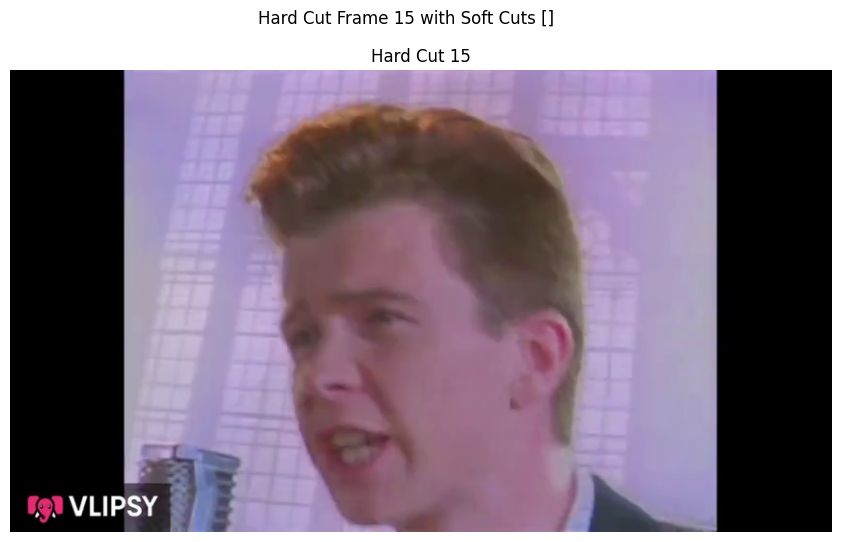

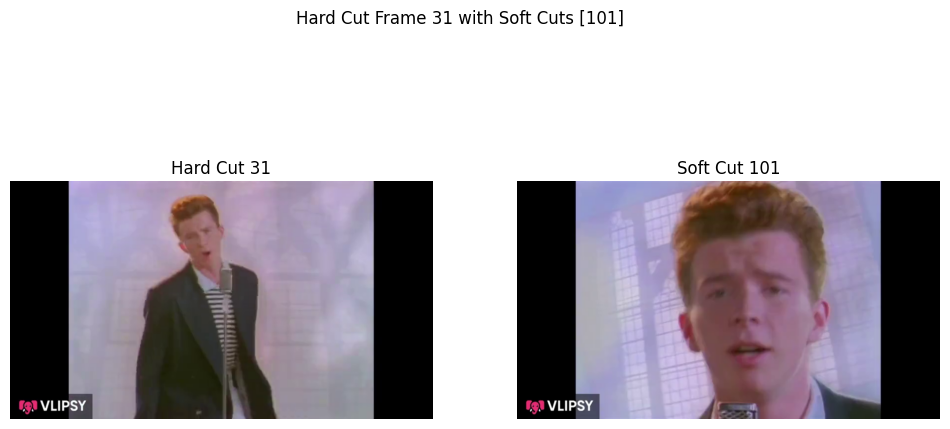

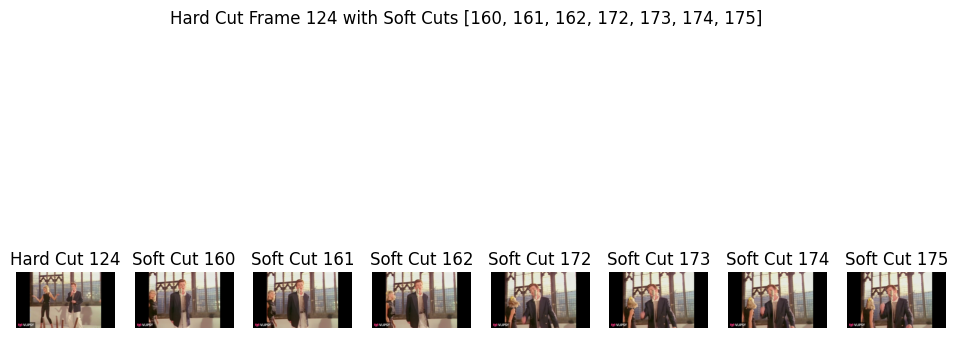

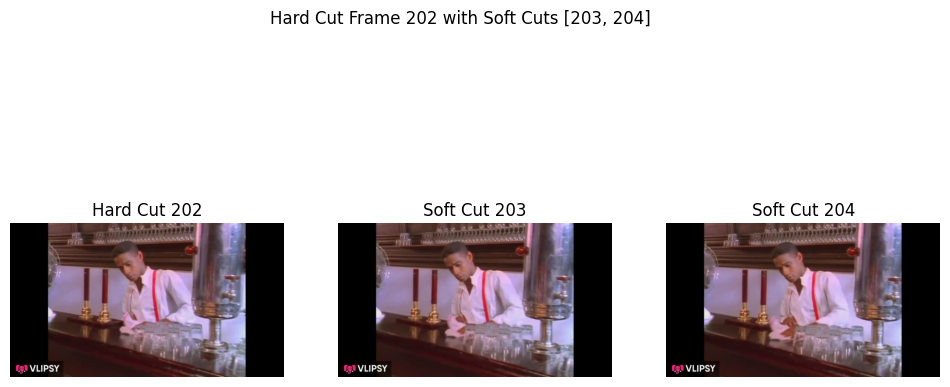

In [ ]:

for group, soft_cut_frames in soft_cuts_by_group.items():
    hard_cut_frame = hard_cuts[group][0] if group < len(hard_cuts) else None
    
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Hard Cut Frame {hard_cut_frame} with Soft Cuts {soft_cut_frames}")

    if hard_cut_frame is not None:
        hard_cut_path = f"output_frames/frame_{hard_cut_frame:04d}.png"
        hard_cut_img = cv2.imread(hard_cut_path)
        if hard_cut_img is not None:
            plt.subplot(1, len(soft_cut_frames) + 1, 1)
            plt.imshow(cv2.cvtColor(hard_cut_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Hard Cut {hard_cut_frame}")
            plt.axis('off')
        else:
            print(f"Error: Hard cut frame {hard_cut_frame} not found.")

    for i, soft_frame_id in enumerate(soft_cut_frames, start=2):
        soft_frame_path = f"output_frames/frame_{soft_frame_id:04d}.png"
        soft_cut_img = cv2.imread(soft_frame_path)
        if soft_cut_img is not None:
            plt.subplot(1, len(soft_cut_frames) + 1, i)
            plt.imshow(cv2.cvtColor(soft_cut_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Soft Cut {soft_frame_id}")
            plt.axis('off')
        else:
            print(f"Error: Soft cut frame {soft_frame_id} not found.")
    
    plt.show()

In [ ]:
print(f"Total Hard Cuts Detected: {len(hard_cuts)}")
print("Hard Cut Frames:", [hc[0] for hc in hard_cuts])
print("Soft Cuts Grouped by Hard Cuts:", soft_cuts_by_group)


Total Hard Cuts Detected: 4
Hard Cut Frames: [15, 31, 124, 202]
Soft Cuts Grouped by Hard Cuts: {0: [], 1: [101], 2: [160, 161, 162, 172, 173, 174, 175], 3: [203, 204]}


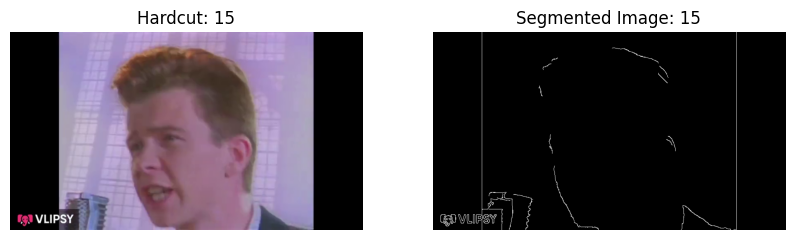

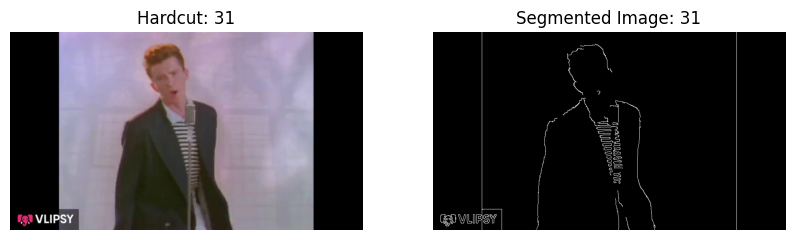

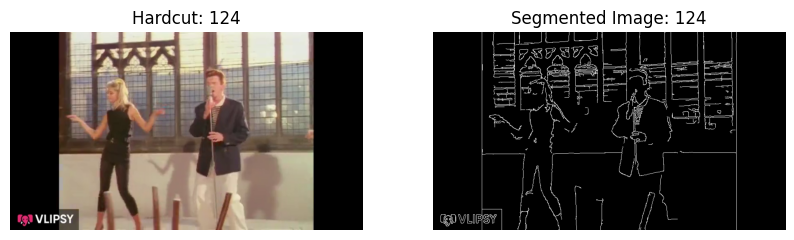

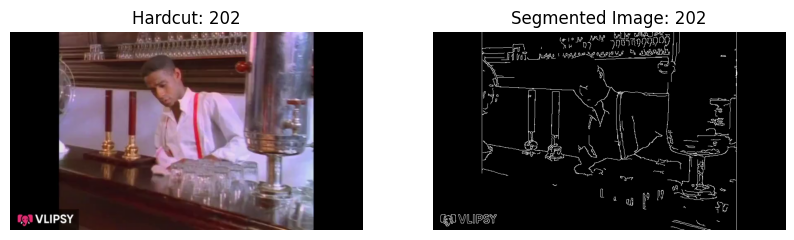

In [ ]:

for i in range(len(hard_cuts)):
    frame_id = hard_cuts[i][0]
    frame_path = f"output_frames/frame_{str(frame_id).zfill(4)}.png"
    segment_path = f"output_segments/segmented_{str(frame_id).zfill(4)}.png"
    frame = cv2.imread(frame_path)
    segment = cv2.imread(segment_path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    segment = cv2.cvtColor(segment, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(frame)
    plt.title(f"Hardcut: {frame_id}")
    plt.axis('off')  

    plt.subplot(1, 2, 2)
    plt.imshow(segment)
    plt.title(f"Segmented Image: {frame_id}")
    plt.axis('off')  

    plt.show()